In [1]:
import pandas as pd
import os
import numpy as np
import logomaker
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from VasculitisTCR.utils.TCR import TCR
from tcrdist.repertoire import TCRrep
import networkx as nx
from networkx.algorithms import community
import umap.umap_ as umap
import tcrdist

In [30]:
# Read in Metadata
basefolder = ""
datafolder = ""
plotsfolder = 'plots'
namesfile = "all_sample_metadata.csv"
metadata = pd.read_csv(os.path.join(basefolder, namesfile))
# exclude samples with unknown age
metadata_age = metadata[~metadata['Age'].isin(['Unknown', 'nk'])]
metadata_gDNA = metadata[metadata['gDNA']==1]

all_gca_tcrs = pd.read_csv(os.path.join(basefolder, 'TCRs_for_clustering/all_GCA_tcrs_clean_nodup.csv'))
tcrs_to_analyze = pd.read_csv(os.path.join(basefolder,'resulting_TCRs/', 'clustering1and3_top1000_highandmedconf.csv'))

In [3]:
# Read in NN files
NN_tcrs = pd.read_csv(os.path.join(datafolder, 'NN_tcrs.csv'))
NN_tcrs['ID'] = [row['v_b_gene']+row['j_b_gene']+row['cdr3_b_aa'] for i,row in NN_tcrs.iterrows()]
NN_dist = pd.read_csv(os.path.join(datafolder, 'NN19.csv'))
NN_dist['ID1'] = [tcrs_to_analyze.iloc[x]['ID'] for x in NN_dist['TCR1']]
NN_dist['ID2'] = [NN_tcrs.iloc[x]['ID'] for x in NN_dist['TCR2']]
# drop all NN which are not in suspicious set - what are we left with?
NN_dist_red = NN_dist[NN_dist['ID2'].isin(tcrs_to_analyze['ID'])]
NN_dist_red = NN_dist_red[NN_dist_red['Distance'] != 1]

In [5]:
# make int IDs
id_dict={}
i=0
for tcr in set(NN_dist_red['ID1']).union(set(NN_dist_red['ID2'])):
    id_dict[tcr] = i
    i+=1

In [7]:
NN_dist_red['Source'] = NN_dist_red['ID1'].apply(lambda x: id_dict[x])
NN_dist_red['Target'] = NN_dist_red['ID2'].apply(lambda x: id_dict[x])
NN_dist_red['Weight'] = NN_dist_red['Distance'].apply(lambda x: 100-x)

In [8]:
G = nx.from_pandas_edgelist(NN_dist_red, source='Source', target='Target', edge_attr=["Weight"])
H = G.to_undirected()
edges = NN_dist_red[['Source', 'Target', 'Weight']]
nodes = list(set(NN_dist_red['ID1']).union(NN_dist_red['ID2']))
nodes = pd.DataFrame(nodes, columns=['ID'])
nodes['Int_ID'] = nodes['ID'].apply(lambda x: id_dict[x])

In [10]:
# Get Communities
communities_generator = community.girvan_newman(H)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
next_level_communities2 = next(communities_generator)
next_level_communities3 = next(communities_generator)
print(len(top_level_communities),len(next_level_communities),len(next_level_communities2),len(next_level_communities3),)


73 74 75 76


In [11]:
cluster_dict = {}
for i,cluster in enumerate(next_level_communities3):
    for id in cluster:
        cluster_dict[id] = i
nodes.rename(columns={
    'Int_ID': 'Id',
    'ID': 'Label',
    }, inplace=True)
nodes['cluster'] = nodes['Id'].apply(lambda x: cluster_dict[x])
#nodes.to_csv(os.path.join(datafolder, 'nodes.csv'), index=None)

In [60]:
# Get sequence logos of Clusters
big_clusters = [x+1 for x in Counter(nodes['cluster']).keys() if Counter(nodes['cluster'])[x]>=15]
cluster_logos={}
aligned_seqs={}
for cluster in big_clusters:
    aligned_cluster=[]
    subset = nodes[nodes['cluster'] == cluster]
    for i,row in subset.iterrows():
        tcr_row = tcrs_to_analyze[tcrs_to_analyze['ID'] == row['Label']]
        v = tcr_row['v_b_gene'].values[0]
        j = tcr_row['j_b_gene'].values[0]
        cdr3 = tcr_row['cdr3_b_aa'].values[0]
        tcr = TCR(v, j, cdr3)
        aligned_cluster.append(tcr.aligned())
        aligned_seqs[v+j+cdr3]=tcr.aligned()
    cluster_logos[cluster] = aligned_cluster
#throw out unsuccessful alignments
for cluster in big_clusters:
    aligned = cluster_logos[cluster]
    aligned = [x for x in aligned if len(x) == 14]
    cluster_logos[cluster]=aligned

In [61]:
big_clusters

[1, 2, 10, 4, 22, 5, 18, 6, 3, 7]

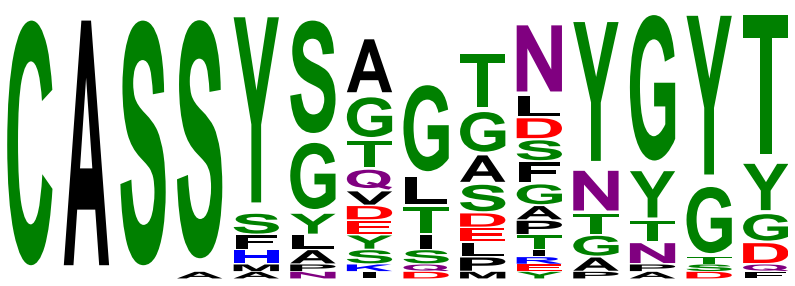

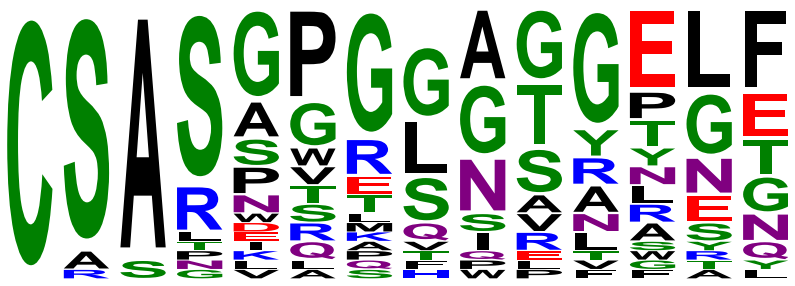

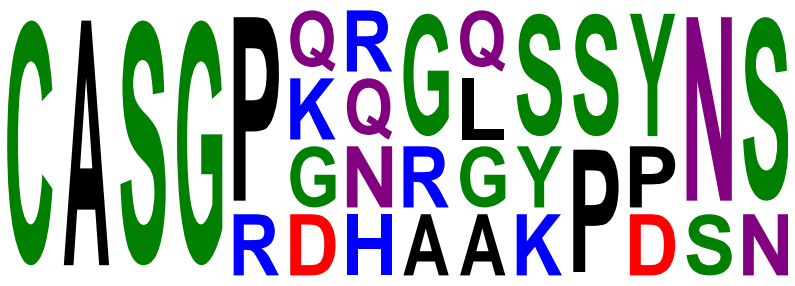

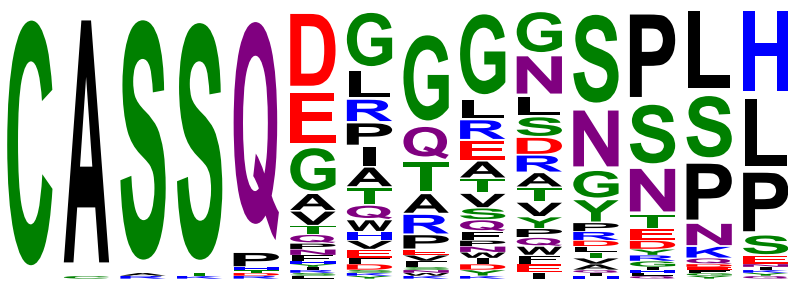

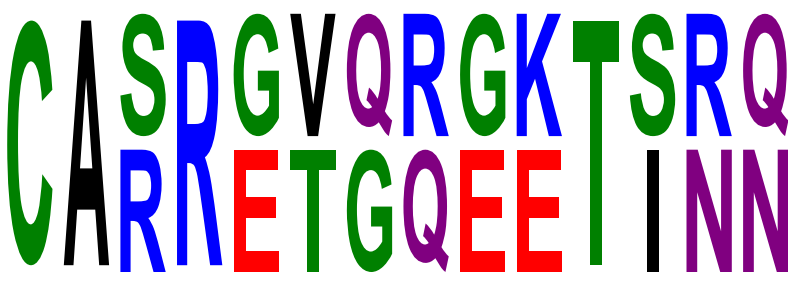

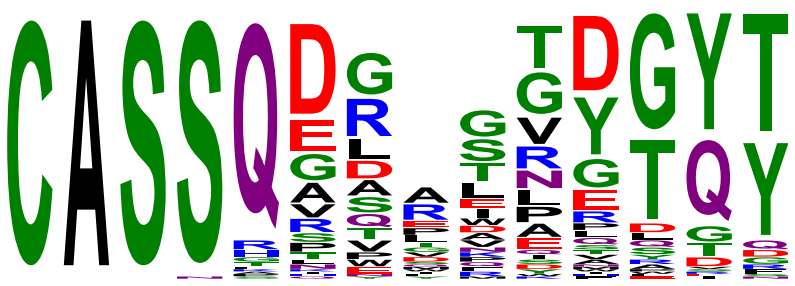

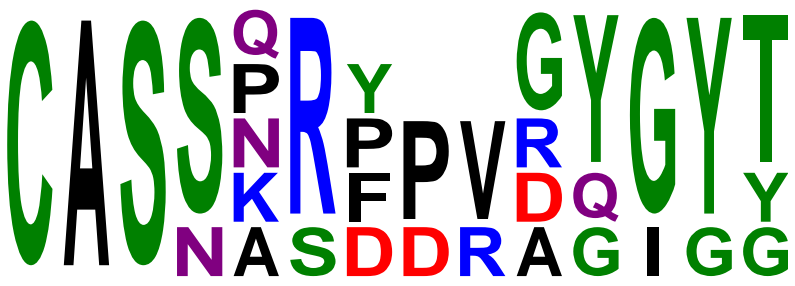

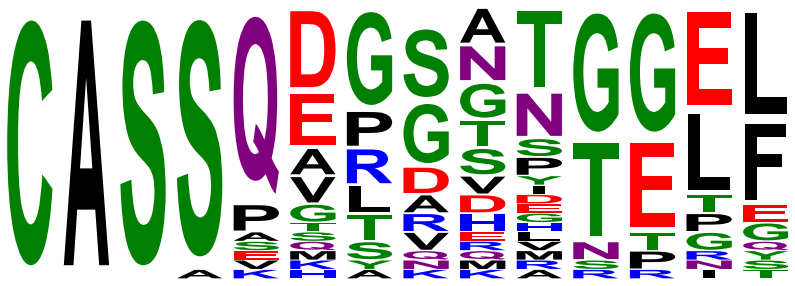

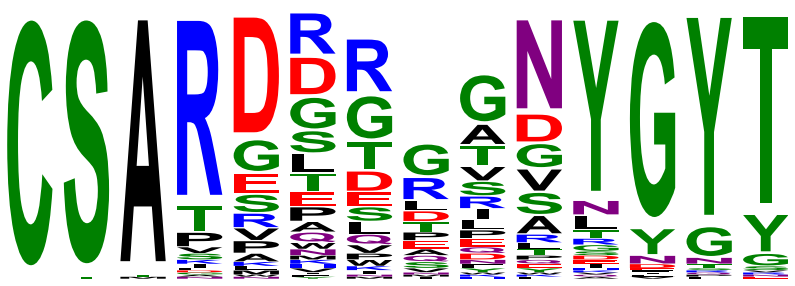

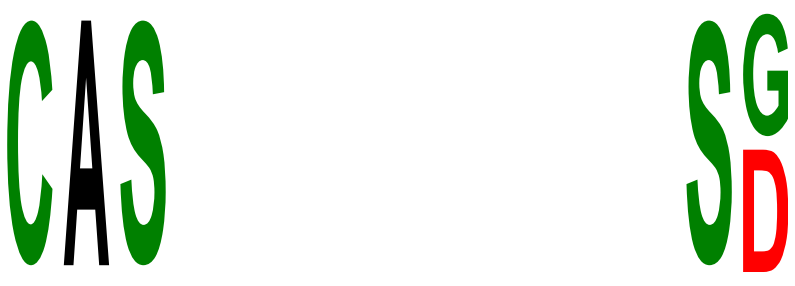

In [62]:
# plot logos for big clusters
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)
for cluster in big_clusters:
    fig = plt.figure(figsize= [14,5])
    #plt.title('Cluster '+str(cluster))
    crp_df = logomaker.alignment_to_matrix(cluster_logos[cluster],to_type = 'counts')
    ax = fig.add_subplot(111)
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    plt.axis('off')
    crp_logo = logomaker.Logo(crp_df,vpad=.1,width=.8,color_scheme='chemistry',ax = ax)
    #plt.savefig(os.path.join(basefolder,plotsfolder, 'cluster_'+str(cluster)+'.pdf'))

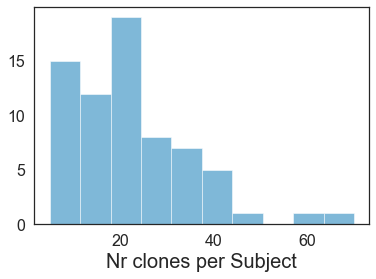

In [16]:
# How many sequences per subject?
clones_per_subject = Counter(tcrs_to_analyze['Name']).values()
fig, ax = plt.subplots()
ax.hist(clones_per_subject, density=False, alpha=0.5)
ax.set_xlabel('Nr clones per Subject',fontsize=20)
ax.set_ylabel('',fontsize=1)
ax.tick_params(labelsize=16)
#plt.savefig(os.path.join(basefolder,plotsfolder, 'clones_per_subject_highandmedconf.pdf'), bbox_inches = "tight")

In [32]:
# Add cluster ID to tcrs_to_analyze
id_to_cluster = {}
for id in tcrs_to_analyze['ID']:
    if id in set(nodes['Label']):
        cluster_id = nodes[nodes['Label'] == id]['cluster'].values[0]
        if len(nodes[nodes['cluster'] == cluster_id]) >= 15:
            id_to_cluster[id] = str(cluster_id+1)
        else:
            id_to_cluster[id] = '0'
    else:
        id_to_cluster[id] = '0'
tcrs_to_analyze_subset = tcrs_to_analyze[tcrs_to_analyze['ID'].isin(nodes['Label'])]
tcrs_to_analyze_subset['Int_ID'] = [nodes[nodes['Label'] == x]['Id'].values[0] for x in tcrs_to_analyze_subset['ID']]
tcrs_to_analyze_subset['cluster'] = tcrs_to_analyze_subset['Int_ID'].apply(lambda x: cluster_dict[x])
tcrs_to_analyze_subset['aligned'] = [aligned_seqs[x] if x in aligned_seqs.keys() else '' for x in tcrs_to_analyze_subset['ID']]
tcrs_to_analyze['cluster'] = tcrs_to_analyze['ID'].apply(lambda x: id_to_cluster[x])

/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [33]:
for c in big_clusters:
    print(c, len(tcrs_to_analyze[tcrs_to_analyze['cluster']==str(c)]))

1 312
4 128
6 112
5 92
10 69
18 43
2 37
3 29
7 29
22 21


In [34]:
tcrs_to_analyze.to_csv(os.path.join(basefolder,'resulting_tcrs', 'clustering1and3_top1000_highandmedconf_clusters.csv'))

In [35]:
tr = TCRrep(cell_df = tcrs_to_analyze,                           #(4)
            organism='human', chains=['beta'],
                    compute_distances=True,
                    deduplicate=False)
distances = tr.pw_beta
um = umap.UMAP(random_state=7538, verbose=False, metric="precomputed")
umout = um.fit_transform(distances)
u1a, u2a = umout.T

/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/wbr/.local/lib/python3.7/site-packages/umap_learn-0.4.0rc1-py3.7.egg/umap/umap_.py:1477: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn("Using precomputed metric; transform will be unavailable for new data")


In [37]:
colors = [
    '#a1c9f4', '#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#00d7ff', '#ffc400'
    ]

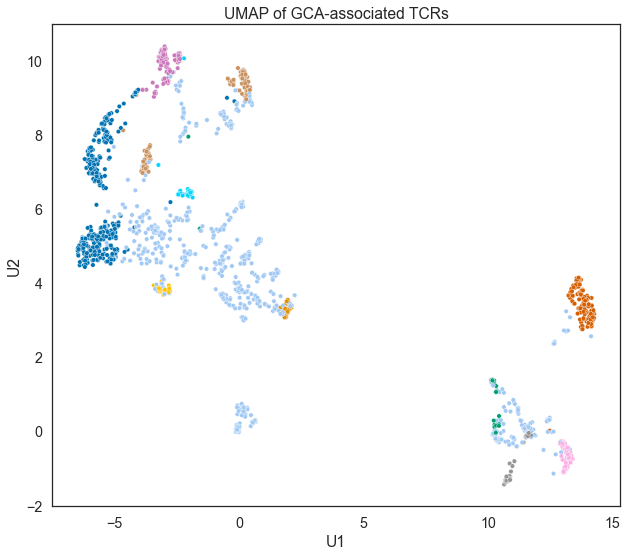

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=u1a, y=u2a,  s=20, ax=ax, hue=tcrs_to_analyze['cluster'], legend=False, palette=sns.color_palette(colors)#, aspect=3
)
fig.set_size_inches(9, 8)
ax.set(title="UMAP of GCA-associated TCRs", xlabel="U1", ylabel="U2")

fig.tight_layout()
#fig.savefig(os.path.join(basefolder, plotsfolder, "umap_TCRs2.pdf"))


In [39]:
# Which V and J segments dominate the clusters?
for cluster in set(tcrs_to_analyze['cluster']):
    if len(tcrs_to_analyze[tcrs_to_analyze['cluster']==cluster]) >= 15:
        print(cluster)
        vCounter = Counter(tcrs_to_analyze[tcrs_to_analyze['cluster']==cluster]['v_b_gene'])
        jCounter = Counter(tcrs_to_analyze[tcrs_to_analyze['cluster']==cluster]['j_b_gene'])
        vpercentage = np.max([x for x in vCounter.values()])/np.sum([x for x in vCounter.values()])
        jpercentage = np.max([x for x in jCounter.values()])/np.sum([x for x in jCounter.values()])
        print(vCounter, vpercentage)
        print(jCounter, jpercentage)

7
Counter({'TRBV4-2*01': 23, 'TRBV4-1*01': 6}) 0.7931034482758621
Counter({'TRBJ2-2*01': 28, 'TRBJ1-5*01': 1}) 0.9655172413793104
10
Counter({'TRBV20-1*01': 59, 'TRBV20-1*02': 5, 'TRBV20-1*04': 2, 'TRBV20-1*05': 2, 'TRBV20-1*06': 1}) 0.855072463768116
Counter({'TRBJ1-5*01': 68, 'TRBJ2-1*01': 1}) 0.9855072463768116
1
Counter({'TRBV4-3*01': 145, 'TRBV4-1*01': 127, 'TRBV4-2*01': 38, 'TRBV12-3*01': 1, 'TRBV4-2*02': 1}) 0.46474358974358976
Counter({'TRBJ2-1*01': 226, 'TRBJ2-3*01': 26, 'TRBJ1-5*01': 18, 'TRBJ2-4*01': 11, 'TRBJ2-7*01': 8, 'TRBJ1-2*01': 8, 'TRBJ2-5*01': 7, 'TRBJ1-6*02': 2, 'TRBJ1-4*01': 2, 'TRBJ1-3*01': 2, 'TRBJ1-6*01': 1, 'TRBJ2-2*01': 1}) 0.7243589743589743
5
Counter({'TRBV4-3*01': 48, 'TRBV4-2*01': 26, 'TRBV4-1*01': 16, 'TRBV5-3*01': 1, 'TRBV24-1*01': 1}) 0.5217391304347826
Counter({'TRBJ1-6*02': 61, 'TRBJ1-6*01': 20, 'TRBJ1-4*01': 8, 'TRBJ1-5*01': 3}) 0.6630434782608695
18
Counter({'TRBV20-1*01': 32, 'TRBV20-1*02': 7, 'TRBV20-1*04': 4}) 0.7441860465116279
Counter({'TRBJ2-4

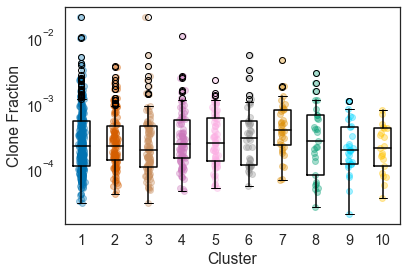

In [72]:
big_clusters_sorted = [1,4,6,5,10,18,2,3,7,22]
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)
colors = [
    '#0173b2', '#d55e00', '#ca9161', '#cc78bc', '#fbafe4', '#949494',   '#de8f05', '#029e73',  '#00d7ff', '#ffc400'
    ]
clusterCounts = {}
clusterFract = {}
for cluster in big_clusters_sorted:
    subset = tcrs_to_analyze[tcrs_to_analyze['cluster'] == str(cluster)]
    clusterCounts[int(cluster)] = subset['cloneCount'].to_list()
    clusterFract[int(cluster)] = subset['cloneFraction'].to_list()

fig, ax = plt.subplots()

colorpalette = sns.color_palette(colors)
vals=[clusterFract[x] for x in big_clusters_sorted]
xs=[]
for i,cluster in enumerate(big_clusters_sorted):
    xs.append(np.random.normal(i+1, 0.04, len(clusterFract[cluster])))
plt.boxplot(vals, labels=big_clusters_sorted, boxprops=dict(linewidth=1.5), whiskerprops=dict(linewidth=1.5), medianprops=dict(linewidth=1.5, color='black'))
plt.yscale('log')
clevels = [0,1,2,3,4,5,6,7,8,9,10]
for i,(x, val) in enumerate(zip(xs, vals)):
    plt.scatter(x, val, alpha=0.35, color=colors[i])
ax.set_ylabel('Clone Fraction')
ax.set_xlabel('Cluster')
# Rename clusters from 1 to five by size (see old cluster names sorted by size above)
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
plt.savefig(os.path.join(basefolder,plotsfolder, 'clusterFract.pdf'),bbox_inches='tight')

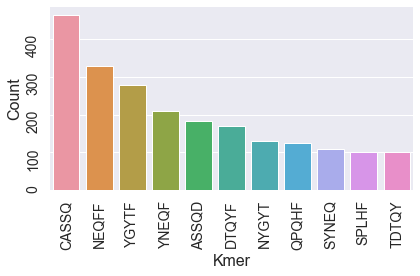

In [68]:
########### KMers #############
# K-mer search
k=5
sequences=tcrs_to_analyze['cdr3_b_aa'].to_list()
kmer_dict={}
def build_dict(kmer, kmer_dict):
    if kmer in kmer_dict.keys():
        kmer_dict[kmer]+=1
    else:
        kmer_dict[kmer]=1
    return kmer_dict
for sequence in sequences:
    if len(sequence) > k:
        for i in range(len(sequence)-k+1):
            kmer = sequence[i:k+i]
            kmer_dict = build_dict(kmer, kmer_dict)

kmer_dataframe=[]
kmers_sorted = sorted(kmer_dict, key=kmer_dict.get, reverse=True)
for kmer in kmers_sorted:
    if kmer_dict[kmer] > 100:
        kmer_dataframe.append([kmer, kmer_dict[kmer]])
kmer_dataframe = pd.DataFrame(kmer_dataframe, columns=['kmer', 'count'])

# Plot kmer dictionary 
sns.set_theme()  
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=False)
splot1 = sns.barplot(data=kmer_dataframe, x='kmer', y='count')
splot1.yaxis.grid(True, clip_on=False)     
ax1.set_ylabel('Count',fontsize=16)
ax1.tick_params(labelsize=14, rotation=90)                                     
ax1.set_xlabel('Kmer',fontsize=16 )    
sns.despine(left=True, bottom=True)       
plt.tight_layout()
#plt.savefig('/Users/wbr/OneDrive - University of Leeds/Statistics/k'+str(k)+'_suspicious_'+input_name+'.pdf')